In [1]:
import keras
from IPython.display import SVG
from keras.optimizers import Adam
from keras.utils.vis_utils import model_to_dot
from tqdm import tqdm

from keras import backend as K

from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, Input

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


import gensim
from gensim import utils
import nltk

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

# plt.xkcd()

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

Using TensorFlow backend.


In [2]:
df_bills = pd.read_csv('../data/bill_all.csv')
print(df_bills.columns)
df_bills.tail()

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'index', 'Unnamed: 0.1.1.1.1', 'action_date', 'action_time', 'chamber',
       'congress', 'legis_num', 'majority', 'name', 'party', 'role',
       'rollcall_num', 'session', 'state', 'vote', 'vote_desc',
       'vote_question', 'vote_result', 'vote_type', 'link', 'billText',
       'sponsor', 'sponsor_id', 'sponsor_party', 'sponsor_state',
       'sponsor_uri'],
      dtype='object')


,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,Unnamed: 0.1.1.1,index,Unnamed: 0.1.1.1.1,action_date,action_time,chamber,congress,...,vote_question,vote_result,vote_type,link,billText,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
4057,4057,4057,4057,4057,5158792,5158792,13-Dec-2011,6:59 PM,U.S. House of Representatives,112,...,On Motion to Suspend the Rules and Pass,Passed,2/3 RECORDED VOTE,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,John W. Olver,O000085,D,MA,https://api.propublica.org/congress/v1/members...
4058,4058,4058,4058,4058,5160455,5160455,14-Dec-2011,6:17 PM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,congressional bills 112th congress u.s governm...,Ileana Ros-Lehtinen,R000435,R,FL,https://api.propublica.org/congress/v1/members...
4059,4059,4059,4059,4059,5161291,5161291,14-Dec-2011,6:31 PM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,Stephen Fincher,F000458,R,TN,https://api.propublica.org/congress/v1/members...
4060,4060,4060,4060,4060,5165452,5165452,16-Dec-2011,11:54 AM,U.S. House of Representatives,112,...,"On Motion to Suspend the Rules and Pass, as Am...",Passed,2/3 RECORDED VOTE,https://www.congress.gov/bill/112th-congress/h...,congressional bills 112th congress u.s governm...,Mark Udall,U000038,D,CO,https://api.propublica.org/congress/v1/members...
4061,4061,4061,4061,4061,5166702,5166702,16-Dec-2011,2:04 PM,U.S. House of Representatives,112,...,On Passage,Passed,YEA-AND-NAY,https://www.congress.gov/bill/112th-congress/h...,112th congress public law u.s government print...,Harold Rogers,R000395,R,KY,https://api.propublica.org/congress/v1/members...


In [3]:
df_final = pd.read_csv('../data/df_vote_final.csv')
df_final = df_final[df_final['vote'].isin(['Yea', 'Nay'])]
print(df_final['vote'].unique())
df_final.tail()

['Yea' 'Nay']


,Unnamed: 0,level_0,index,Unnamed: 0.1,action_date,action_time,chamber,congress,legis_num,majority,...,vote,vote_desc,vote_question,vote_result,vote_type,sponsor,sponsor_id,sponsor_party,sponsor_state,sponsor_uri
5103690,5103690,413,2835512,2835512,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103691,5103691,414,2835513,2835513,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103692,5103692,415,2835514,2835514,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103693,5103693,416,2835515,2835515,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...
5103694,5103694,417,2835516,2835516,19-Mar-2015,12:08 PM,U.S. House of Representatives,114,S J RES 8,R,...,Yea,Providing for congressional disapproval under ...,On Passage,Passed,YEA-AND-NAY,Lamar Alexander,A000360,R,TN,https://api.propublica.org/congress/v1/members...


In [4]:
df_final.columns

Index(['Unnamed: 0', 'level_0', 'index', 'Unnamed: 0.1', 'action_date',
       'action_time', 'chamber', 'congress', 'legis_num', 'majority', 'name',
       'party', 'role', 'rollcall_num', 'session', 'state', 'vote',
       'vote_desc', 'vote_question', 'vote_result', 'vote_type', 'sponsor',
       'sponsor_id', 'sponsor_party', 'sponsor_state', 'sponsor_uri'],
      dtype='object')

In [5]:
word2vec_model = gensim.models.KeyedVectors.load_word2vec_format('/home/sonic/.keras/datasets/GoogleNews-vectors-negative300.bin',
                                                        binary=True)


In [6]:
%%time

max_words = 20000
MAX_SEQUENCE_LENGTH = 1000
def process_doc(X):
    tokenizer = Tokenizer(num_words=max_words,lower=True, split=' ', 
                          filters='"#%&()*+-/<=>@[\\]^_`{|}~\t\n',
                          char_level=False, oov_token=u'<UNK>')

    X_text = X['billText'].values
    tokenizer.fit_on_texts(X_text)
    print(X.shape)
    
    X_seq = np.array(tokenizer.texts_to_sequences(X_text))
    X_seq = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
    print('X_seq', X_seq.shape)

    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(X_text)

    tf_transformer = TfidfTransformer().fit(X_train_counts)
    X_train_tf = tf_transformer.transform(X_train_counts)

    x_emb = {}
    #     tokens = nltk.word_tokenize(list(X))
#     print('tokens.shape', tokens.shape)

    for idx, doc in tqdm(X.iterrows()): #look up each doc in model
#         print(doc['legis_num'], doc['billText'])
        x_emb[doc['legis_num']] = document_vector(word2vec_model, nltk.word_tokenize(doc['billText'].lower()))


    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))


    return np.array(X_seq), word_index, x_emb, X_train_tf, X_train_counts

def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in word2vec_model.vocab]
    return np.mean(word2vec_model[doc], axis=0)


def has_vector_representation(word2vec_model, doc):
    """check if at least one word of the document is in the
    word2vec dictionary"""
    return not all(word not in word2vec_model.vocab for word in doc)


df_bills['billText'] = df_bills['billText'].apply(str)
X_seq, word_index, X_emb, X_train_tf, X_train_counts = process_doc(df_bills)
# df_bills['X_seq'] = X_seq
# df_bills['X_emb'] = X_emb
# df_bills['X_train_tf'] = X_train_tf
# df_bills['X_train_counts'] = X_train_counts

# print(X_emb.shape)
print(X_emb['H R 5010'].shape)

(4062, 30)
X_seq (4062, 1000)


4062it [01:19, 50.92it/s]

Found 97804 unique tokens.
(300,)
CPU times: user 1min 34s, sys: 664 ms, total: 1min 34s
Wall time: 1min 34s


In [7]:
def plot_history(history):
#     print(history.history)
    df = pd.DataFrame(history.history)
    print(df.describe())
    df.plot(xticks=range(epochs))
#     print(history.history.keys())


In [8]:
# #plot data
# fig, ax = plt.subplots(figsize=(15,7))
# # print(dataset.groupby(['name'])['legis_num'].count())
# print()
# dataset.groupby(['name_id'])['legis_num'].count().plot(kind='hist', bins=100, alpha=0.5)
# # dataset.groupby(['name']).count()['legis_num'].plot(ax=ax, kind='hist', bins=100, alpha=0.5)
# plt.show()
# # print(dataset.groupby(['legis_num'])['name_id'].count())
# # dataset.groupby(['legis_num'])['name_id'].count().plot(kind='hist', bins=10, alpha=0.5)

In [9]:
# load the whole embedding into memory
embeddings_index = dict()
f = open('/home/sonic/.keras/datasets/glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))


Loaded 400000 word vectors.


In [10]:

n_latent_factors = 100
EMBEDDING_DIM = 100

vocab_size = len(word_index) + 1
print(len(word_index))

# create a weight matrix for words in training docs
embedding_matrix = zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


97804


In [11]:
from keras.initializers import glorot_uniform  # Or your initializer of choice
from tqdm import tqdm

def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

def getEmbeddingModel():
    # define model
    model = Sequential()
    e = Embedding(300, EMBEDDING_DIM, input_length=300, name='embedding_layer', trainable=True)
    model.add(e)
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid', name='pred'))
    # compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
    return model

def getEmbeddingConvModel():
    sequence_input = Input(shape=(300,), dtype='int32')
    embedding = Embedding(300, EMBEDDING_DIM, input_length=300, name='embedding_layer')
    embedded_sequences = embedding(sequence_input)
    x = Conv1D(256, 4, activation='relu')(embedded_sequences)
    x = MaxPooling1D(4)(x)
    x = Conv1D(128, 4, activation='relu')(x)
    x = MaxPooling1D(4)(x)
    x = Conv1D(64, 4, activation='relu')(x)
    x = MaxPooling1D(4)(x)  # global max pooling
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    preds = Dense(1, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['acc'])
    return model

# print(embedding_matrix.shape)
# print(vocab_size)

In [12]:
import pandas as pd
from collections import Counter

def get_class_weights(y):
    counter = Counter(y)
    majority = max(counter.values())
    return  {cls: round(float(majority)/float(count), 2) for cls, count in counter.items()}


In [13]:
%%time


from sklearn.dummy import DummyClassifier
from keras.layers import Input, Embedding, Dense, Flatten, Dropout, concatenate
from keras.layers import BatchNormalization, SpatialDropout1D
from keras.callbacks import Callback
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import Normalizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.utils import class_weight
from sklearn import metrics


def getDataset(df):
    dataset = df[['name', 'legis_num', 'vote', 'party',
                  'sponsor_party', 'sponsor_state', 'sponsor_id']]
#     print(df.columns)
    dataset['bill_id'] = dataset.legis_num.astype('category').cat.codes.values
    dataset['name_id'] = dataset.name.astype('category').cat.codes.values
    dataset['vote_orig'] = dataset['vote']
    dataset['vote'] = dataset.vote.astype('category').cat.codes.values

    dataset['sponsor_party'] = dataset.sponsor_party.astype('category').cat.codes.values
    dataset['sponsor_id'] = dataset.sponsor_id.astype('category').cat.codes.values
    dataset['sponsor_state'] = dataset.sponsor_state.astype('category').cat.codes.values
    # dataset.drop(columns=['name', 'legis_num'], inplace=True)
    dataset = dataset.sample(frac=0.5, replace=True)
    dataset.reset_index(inplace=True)
    return dataset


def get_matrix_factorisation(n_bill, n_users):
    legistlator_input = keras.layers.Input(shape=[1], name='legistlator')
    legistlator_embedding = keras.layers.Embedding(n_users, n_latent_factors, mask_zero=False,
                                                   embeddings_initializer='lecun_uniform',
                                                   name='legistlator-Embedding')(legistlator_input)
    legistlator_vec = keras.layers.Flatten(name='FlattenLegistlator')(legistlator_embedding)
    
    bill_input = keras.layers.Input(shape=[1], name='bill')
    bill_embedding = keras.layers.Embedding(n_bill, n_latent_factors, mask_zero=False, 
                                            embeddings_initializer='lecun_uniform',
                                            name='bill-Embedding')(bill_input)
    bill_vec = keras.layers.Flatten(name='FlattenBill')(bill_embedding)

    prod = keras.layers.dot([bill_vec, legistlator_vec], axes=1, name='DotProduct')
    model = keras.Model([legistlator_input, bill_input], prod)
    model.compile('adam', 'mean_squared_error')
    # SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, rankdir='HB').create(prog='dot', format='svg'))
    return model


def runEmbeddingModel(train_df, n_users, n_bill):
    embedding_learnt_all = {}
    accuracy_all = {}
    cp_party = {}
    
    model = getEmbeddingModel()
#     model = getEmbeddingConvModel()
#     print(model.summary())
    reset_weights(model)
    
    print("running embedding mode;")
    for name, group in tqdm(train_df.groupby(['name_id'])):
#         print(name, group.iloc[0]['name'])

        labels = []
        padded_docs = []
        for ind, vote in group.iterrows():
            padded_docs.append(X_emb[vote['legis_num']])
            labels.append(vote['vote'])

        padded_docs = np.array(padded_docs)
        labels = np.array(labels)

        reset_weights(model)
        # fit the model
        history = model.fit(padded_docs, labels, epochs=epochs, verbose=0)
        # plot_history(history)

        # evaluate the model
        loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
        accuracy_all[group.iloc[0]['name']] = {'loss' : loss, 'accuracy' : accuracy}
    #     print('Accuracy: %f' % (accuracy*100))

#         print('legistlar embedding', model.get_layer(name='embedding_layer').get_weights()[0].shape)
        embedding_learnt_all[group.iloc[0]['name_id']] = model.get_layer(name='embedding_layer').get_weights()[0]
        cp_party[group.iloc[0]['name']] = group['party'].unique()[0]
    
    
    return embedding_learnt_all, accuracy_all, cp_party

def get_padded_labels(df, legistlator_embedding_learnt, bill_embedding_learnt, embedding_learnt_all):
    x_emb = [] 
    x_name = [] 
    x_bill = [] 
    x_emb_learnt = []
    labels = []
    for ind, vote in df.iterrows():
        x_emb.append(X_emb[vote['legis_num']])
        x_name.append(legistlator_embedding_learnt[vote['name_id']])
        x_bill.append(bill_embedding_learnt[vote['bill_id']])
#         x_emb_learnt.append(embedding_learnt_all[vote['name_id']])
        labels.append(vote['vote'])
    return np.array(x_emb), np.array(x_name), np.array(x_bill), np.array(x_emb_learnt), np.array(labels)

def runMultiPredictionModel (train_df, test_df, legistlator_embedding_learnt, bill_embedding_learnt, 
                             baselines, name):

    x_emb_train, x_name_train, x_bill_train, y_train = get_padded_labels(train_df, legistlator_embedding_learnt, bill_embedding_learnt)
    print('x_emb.shape', x_emb_train.shape)
    print('x_name.shape', x_name_train.shape)
    print('x_bill.shape', x_bill_train.shape)
    
    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    
    class_weights = get_class_weights(y_train)
    print(y_train)
    print('Class weights:', class_weights)

    
    convModel = getEmbeddingConvModel()

    # first input model
    visible1 = Input(shape=(300, ), name='bill_embedding', dtype='int32')
    embedding = Embedding(300, EMBEDDING_DIM, input_length=300, name='embedding_layer', trainable=True)
    embedded_sequences = embedding(visible1)
    x = Conv1D(128, 4, activation='relu')(embedded_sequences)
    x = MaxPooling1D(4)(x)
    x = Conv1D(64, 4, activation='relu')(x)
    x = MaxPooling1D(4)(x)
#     x = Conv1D(32, 4, activation='relu')(x)
#     x = MaxPooling1D(4)(x)  # global max pooling
    flat1 = Flatten(name='embedding_flatten')(x)
    
    # second input model
    visible2 = Input(shape=[n_latent_factors], name = 'legislator_cf')
    hidden_legis_cf = Dense(dense_n, activation='relu', name='legislator_cf_flatten')(visible2)
    
    # third input model
    visible3 = Input(shape=[n_latent_factors], name = 'bill_cf')
    hidden_bill_cf = Dense(dense_n, activation='relu', name='bill_cf_flatten')(visible3)
    
    # merge input models
    merge = concatenate([flat1, hidden_legis_cf, hidden_bill_cf])
    merge = BatchNormalization()(merge)
    # interpretation model
    hidden1 = Dense(128, activation='relu')(merge)
    hidden2 = Dense(64, activation='relu')(hidden1)
    output = Dense(1, activation='sigmoid')(hidden2)
    
    model = Model(inputs=[visible1, visible2, visible3], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
    # summarize layers
    print(model.summary())
    # Fit model
    history = model.fit([x_emb_train, x_name_train, x_bill_train], y_train,
                        callbacks=[EarlyStopping(monitor='loss', patience=2)], 
                        epochs=epochs, shuffle=True, class_weight=class_weights, verbose=1)
    plot_history(history)    
    
    # fit the model    
#     history = convModel.fit(x_emb_train, y_train, epochs=epochs, verbose=1, class_weight=class_weights)
#     plot_history(history)

    # evaluate the model
    print('Evaluating model')
    x_emb_test, x_name_test, x_bill_test, y_test = get_padded_labels(test_df, legistlator_embedding_learnt, bill_embedding_learnt)
    y_predict = model.predict([x_emb_test, x_name_test, x_bill_test])
    baselines.append({'clfName' : 'Multi','congress': name,
                      'mse' : mean_squared_error(y_test, y_predict.round()), 
                      'accuracy' : accuracy_score(y_test, y_predict.round())})
    print(metrics.classification_report(y_test, y_predict.round(), labels=[0, 1]))
    ##################################################################################################
#     print('RUN CONV Simple', '*'*50)
#     print(convModel.summary())
#     # evaluate the model
#     y_predict = convModel.predict(x_emb_test)
#     baselines.append({'clfName' : 'Conv', 'congress': name,
#                       'mse' : mean_squared_error(y_test, y_predict.round()), 
#                       'accuracy' : accuracy_score(y_test, y_predict.round())})
    
    

def runBaseLines(train, test, clf,clfName, name):
    clf.fit(train[['sponsor_id', 'sponsor_party', 'sponsor_state']], train.vote)
    y_predict = clf.predict(test[['sponsor_id', 'sponsor_party', 'sponsor_state']])
    model_mse = mean_squared_error(test.vote, y_predict)
    print(clf)
    print(metrics.classification_report(test.vote, y_predict.round(), labels=[0, 1]))
    return {'clfName' : clfName, 'mse' : model_mse, 'accuracy' : accuracy_score(test.vote, y_predict), 'congress': name}


CPU times: user 8 ms, sys: 4 ms, total: 12 ms
Wall time: 11.1 ms


In [14]:
def runMultiMetaModel(train_df, test_df, embedding_learnt_all, 
                      legistlator_embedding_learnt, bill_embedding_learnt, baselines, name):
    x_emb_train, x_name_train, x_bill_train, x_emb_learnt, y_train = get_padded_labels(train_df, legistlator_embedding_learnt,
                                                                         bill_embedding_learnt, embedding_learnt_all)
    x_emb_train = np.expand_dims(x_emb_train, axis=2) 
    print('x_emb.shape', x_emb_train.shape)
    print('x_name.shape', x_name_train.shape)
    print('x_bill.shape', x_bill_train.shape)
    print('x_emb_learnt.shape', x_emb_learnt.shape)
#     class_weights = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
    class_weights = get_class_weights(y_train)
    print('Class weights:', class_weights)

    # first input model
    visible1 = Input(shape=(300, 1), name='bill_input')
    x = Conv1D(128, 4, activation='relu')(visible1)
    x = MaxPooling1D(4)(x)
    x = Conv1D(64, 4, activation='relu')(x)
    x = MaxPooling1D(4)(x)
#     x = Conv1D(32, 4, activation='relu')(x)
#     x = MaxPooling1D(4)(x)  # global max pooling
    flat1 = Flatten(name='embedding_flatten')(x)
    
    # second input model
    legistlator_input = Input(shape=[1], name='legis_input')
    legistlator_embedding = Embedding(n_users, n_latent_factors, mask_zero=False,
                                                   embeddings_initializer='lecun_uniform', trainable=True,
                                                   name='legislator-Embedding')(legistlator_input)
    legistlator_vec = Flatten(name='FlattenLegislator')(legistlator_embedding)

    
    # third input model
    visible3 = Input(shape=[n_latent_factors], name = 'legislator_cf')
    hidden_legis_cf = Dense(dense_n, activation='relu', name='legislator_cf_flatten')(visible3)
    
    # merge input models
    merge = concatenate([flat1, legistlator_vec, hidden_legis_cf])
    merge = BatchNormalization()(merge)
    # interpretation model
    hidden1 = Dense(128, activation='relu')(merge)
    hidden2 = Dense(64, activation='relu')(hidden1)
    output  = Dense(1, activation='sigmoid')(hidden2)
    
    model = Model(inputs=[visible1, legistlator_input, visible3], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='RMSprop', metrics=['accuracy', 'mse','mape'])
    # summarize layers
    print(model.summary())
    from keras.utils import plot_model
    plot_model(model, to_file='model.png')
    # Fit model
    history = model.fit([x_emb_train, train_df.name_id, x_name_train], y_train,
                        callbacks=[EarlyStopping(monitor='loss', patience=2)], 
                        epochs=epochs, shuffle=True, class_weight=class_weights, verbose=1)
    plot_history(history)
    
    # evaluate the model
    print('Evaluating model')
    x_emb_test, x_name_test, x_bill_test, x_emb_learnt, y_test = get_padded_labels(test_df, legistlator_embedding_learnt, 
                                                                     bill_embedding_learnt, embedding_learnt_all)
    x_emb_test = np.expand_dims(x_emb_test, axis=2)
    y_predict = model.predict([x_emb_test, test_df.name_id, x_name_test])
    baselines.append({'clfName' : 'Multi','congress': name,
                      'mse' : mean_squared_error(y_test, y_predict.round()), 
                      'accuracy' : accuracy_score(y_test, y_predict.round())})
    print(metrics.classification_report(y_test, y_predict.round(), labels=[0, 1]))


In [15]:
def kraftModel(train_df, test_df):
    inputs = Input(shape=(1,))
    preds = Dense(1,activation='linear')(inputs)

    model = Model(inputs=inputs,outputs=preds)
    sgd = keras.optimizers.SGD()
    model.compile(optimizer=sgd ,loss='mse')
    model.fit(x_,y_, batch_size=1, epochs=10, verbose=1, shuffle=False)

from scipy.stats import norm

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics

# https://github.com/snatch59/keras-autoencoders/blob/master/variational_autoencoder.py
def VAE(X_train, train):
    batch_size = 100
    original_dim = X_train.shape[1]
    latent_dim = 2
    intermediate_dim = 256
    epochs = 50
    epsilon_std = 1.0

    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)


    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon


    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # instantiate VAE model
    vae = Model(x, x_decoded_mean)

    # Compute VAE loss
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop', metrics=['accuracy', 'mse'])
    print(vae.summary())


    history = vae.fit(X_train, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=2)
    plot_history(history)

    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)

    # display a 2D plot of the digit classes in the latent space
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    colors = [ 'b','g', 'r']
    y = []
    cp_party = {}
    
    train = train.drop_duplicates(subset='name_id', keep="last")
    print('train.shape', train.shape)
    for name, group in train.groupby(['name_id']):
        cp_party[group.iloc[0]['name_id']] = group['party'].unique()[0]
        y.append(group['party'].unique()[0])
    
    print(len(cp_party))
#     for i in range(train.shape[0]):
#         y.append(cp_party[i])
        
    print(y)
    le.fit(y)
    print('classes', le.classes_)
    y = le.transform(y)
#     print(y)
    x_test_encoded = encoder.predict(X_train, batch_size=batch_size)
    print('x_test_encoded.shape', x_test_encoded.shape)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y)
#     for color, i, target_name in zip(colors, [0, 1, 2], le.classes_):
#         plt.scatter(x_test_encoded[y == i, 0], x_test_encoded[y == i, 1],
#                     cmap=matplotlib.colors.ListedColormap(colors),
#                     color=color, alpha=.6, lw=2, label=target_name)
    plt.title('Variational Autoencoder')
    plt.colorbar()



def deep_autoencoder(X_train, train):
    print('running autoencoder')
    input_dim = X_train.shape[1]
    x_input = Input(shape=(input_dim, ))
    encoded = Dense(128, activation='relu', kernel_initializer='glorot_uniform')(x_input)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(32, activation='relu',  name='encoded')(encoded)

    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)
    autoencoder = Model(x_input, decoded)
    
#     loss = 'mean_squared_error'
    loss = 'binary_crossentropy'
    autoencoder.compile(optimizer='adam', loss=loss, metrics=['accuracy', 'mse'])
    print(autoencoder.summary())
    history = autoencoder.fit(X_train, X_train, verbose=0, epochs=epochs)
    plot_history(history)
    
    ###
    names = [weight.name for layer in autoencoder.layers for weight in layer.weights]
    weights = autoencoder.get_weights()

    for name, weight in zip(names, weights):
        print(name, weight.shape)
    ########################################################################
    activations = autoencoder.predict(X_train)
    print('activations.shape',activations.shape)
    ########################################################################
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    colors = [ 'b','g', 'r']
    y = []
    cp_party = {}
    for name, group in tqdm(train.groupby(['name_id'])):
        cp_party[group.iloc[0]['name_id']] = group['party'].unique()[0]
    
    print(cp_party)
    for i in range(X_train.shape[0]):
        y.append(cp_party[i])
        
    print(y)
    le.fit(y)
    print(le.classes_)
    y = le.transform(y)
    print(y)
    X_tsne = TSNE(n_components=2, verbose=2).fit_transform(activations)
    from sklearn.decomposition import PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(activations)
    plt.show()
    plt.figure(figsize=(10, 10),)
#     plt.scatter(X_tsne[:, 0], X_tsne[:, 1], label=y, c=colors, 
#                 cmap=matplotlib.colors.ListedColormap(colors), alpha=0.6)

    for color, i, target_name in zip(colors, [0, 1, 2], le.classes_):
        plt.scatter(X_tsne[y == i, 0], X_tsne[y == i, 1], cmap=matplotlib.colors.ListedColormap(colors),
                    color=color, alpha=.6, lw=2, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('TSNE plot')
    plt.show()
    
    plt.figure(figsize=(10, 10),)
    for color, i, target_name in zip(colors, [0, 1, 2], le.classes_):
        plt.scatter(X_pca[y == i, 0], X_pca[y == i, 1], cmap=matplotlib.colors.ListedColormap(colors),
                    color=color, alpha=.6, lw=2, label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA plot')
    plt.show()
    ########################################################################
    return autoencoder

In [21]:
# https://github.com/snatch59/keras-autoencoders/blob/master/variational_autoencoder.py
def VAE(X_train, train):
    batch_size = 100
    original_dim = X_train.shape[1]
    latent_dim = 2
    intermediate_dim = 256
    epochs = 30
    epsilon_std = 1.0

    x = Input(shape=(original_dim,))
    h = Dense(intermediate_dim, activation='relu')(x)
    z_mean = Dense(latent_dim)(h)
    z_log_var = Dense(latent_dim)(h)


    def sampling(args):
        z_mean, z_log_var = args
        epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
        return z_mean + K.exp(z_log_var / 2) * epsilon


    # note that "output_shape" isn't necessary with the TensorFlow backend
    z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

    # we instantiate these layers separately so as to reuse them later
    decoder_h = Dense(intermediate_dim, activation='relu')
    decoder_mean = Dense(original_dim, activation='sigmoid')
    h_decoded = decoder_h(z)
    x_decoded_mean = decoder_mean(h_decoded)

    # instantiate VAE model
    vae = Model(x, x_decoded_mean)

    # Compute VAE loss
    xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss)

    vae.add_loss(vae_loss)
    vae.compile(optimizer='rmsprop', metrics=['accuracy', 'mse'])
    print(vae.summary())


    history = vae.fit(X_train, shuffle=True, epochs=epochs, batch_size=batch_size, verbose=2)
    plot_history(history)

    # build a model to project inputs on the latent space
    encoder = Model(x, z_mean)

    # display a 2D plot of the digit classes in the latent space
    from sklearn import preprocessing
    le = preprocessing.LabelEncoder()
    colors = ['b','g', 'r']
    y = []
    cp_party = {}
    
    train = train.drop_duplicates(subset='name_id', keep="last")
    print('train.shape', train.shape)
    y.append('R')
    for name, group in train.groupby(['name_id']):
        cp_party[group.iloc[0]['name_id']] = group['party'].unique()[0]
        y.append(group['party'].unique()[0])
    
    print(len(cp_party))
#     for i in range(train.shape[0]):
#         y.append(cp_party[i])
        
    print(y)
    le.fit(y)
    print('classes', le.classes_)
    y = le.transform(y)
#     print(y)
    x_test_encoded = encoder.predict(X_train, batch_size=batch_size)
    print('x_test_encoded.shape', x_test_encoded.shape)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y)
#     for color, i, target_name in zip(colors, [0, 1, 2], le.classes_):
#         plt.scatter(x_test_encoded[y == i, 0], x_test_encoded[y == i, 1],
#                     cmap=matplotlib.colors.ListedColormap(colors),
#                     color=color, alpha=.6, lw=2, label=target_name)
    plt.title('Variational Autoencoder')
    plt.colorbar()


In [19]:
dataset = getDataset(df_final)
print(dataset.shape)
n_users, n_bill = len(dataset.name_id.unique()) + 1, len(dataset.bill_id.unique()) + 1
print('number of legsitlators:', n_users)
print('number of bills', n_bill)
#     print(dataset.name_id.unique())

# RUN MATRIX AUTOENCODER #######################################################################
vote_matrix = getVoteMatrix(dataset, n_users, n_bill)
print('running vae')
#     deep_autoencoder(vote_matrix, train)
VAE(vote_matrix, dataset)

(2551848, 11)
number of legsitlators: 1119
number of bills 4062
vote_matrix.shape (1119, 4062)
running vae
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 4062)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          1040128     input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__

NameError: name 'epochs' is not defined

In [ ]:
deep_autoencoder(vote_matrix, dataset)

Processing congress 106
congress shape (242591, 26)
number of legistlators 435
train.shape (97036, 11)
test.shape (24260, 11)
number of legsitlators: 435
number of bills 313
vote_matrix.shape (435, 313)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 313)          0                                            
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          80384       input_3[0][0]                    
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 2)            514         dense_11[0][0]                   
__________________________________________________________________________________________________
dense

ValueError: c of shape (436,) not acceptable as a color sequence for x with size 435, y with size 435

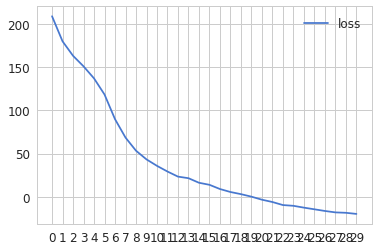

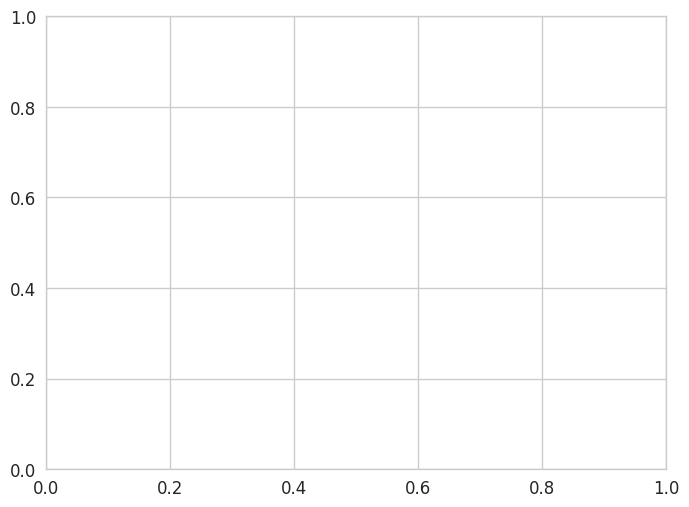

In [22]:
############################################################################################

grouped_congress = df_final.groupby('congress')
embedding_learnt_congress_all = {}
bill_embedding_learnt_all = {}
legistlator_embedding_learnt_all = {}
congress_info = {}
cp_party_all = {}
baselines = []

dense_n = 100
droprate=0.25

#EPOCHS
epochs = 30


for name, group in grouped_congress:
    print('Processing congress', name)
    print('congress shape', group.shape)
    
    df_votes_filtered = df_final[df_final['congress'] == name]
    num_legistlators = len(df_votes_filtered['name'].unique())
    num_bills = len(df_votes_filtered['legis_num'].unique())
    print('number of legistlators', num_legistlators)

    dataset = getDataset(df_votes_filtered)
    train, test = train_test_split(dataset, test_size=0.2)
    print('train.shape', train.shape)
    print('test.shape', test.shape)
    congress_info[name] = {'num_legislators': num_legistlators, 'num_bills' : num_bills, 
                           'dataset.shape' : dataset.shape[0], 'train.shape': train.shape[0], 'test.shape': test.shape[0]}
    
    # Run base model ###############################################################################
#     for clfName, clf in ({'Majority' :  DummyClassifier(strategy="most_frequent"), 
#                   'Decision Tree' : DecisionTreeClassifier(), 
#                   'RandomForest' : RandomForestClassifier()}.items()):
#         baselines.append(runBaseLines(train, test, clf, clfName, name))
    ################################################################################################
    
    n_users, n_bill = len(dataset.name_id.unique()), len(dataset.bill_id.unique())
    print('number of legsitlators:', n_users)
    print('number of bills', n_bill)
#     print(dataset.name_id.unique())
    
    # RUN MATRIX AUTOENCODER #######################################################################
    vote_matrix = getVoteMatrix(train, n_users, n_bill)
    
#     deep_autoencoder(vote_matrix, train)
    VAE(vote_matrix, train)
    ################################################################################################
  
    # Run embedding model ##########################################################################
#     %time embedding_learnt_all, accuracy_all, cp_party = runEmbeddingModel(train, n_users, n_bill)
#     df_performace = pd.DataFrame(accuracy_all)
#     embedding_learnt_congress_all[name] = embedding_learnt_all
#     cp_party_all[name] = cp_party
#     print('average accuracy', df_performace.loc['accuracy'].mean())
#     print('average loss', df_performace.loc['loss'].mean())
    ################################################################################################

    # Run Matrix factorization model ###############################################################
#     print('Runing Matrix Factorisation')
#     MF_model = get_matrix_factorisation(n_bill, n_users)
# #     print(MF_model.summary())
#     %time history = MF_model.fit([train.name_id, train.bill_id], train.vote, epochs=5, verbose=0)
#     plot_history(history)
#     bill_embedding_learnt = MF_model.get_layer(name='bill-Embedding').get_weights()[0]
#     bill_embedding_learnt_all[name] = bill_embedding_learnt
#     legistlator_embedding_learnt = MF_model.get_layer(name='legistlator-Embedding').get_weights()[0]
#     legistlator_embedding_learnt_all[name] = legistlator_embedding_learnt 
#     print('bill_embedding_learnt.shape', bill_embedding_learnt.shape)
#     print('legistlator_embedding_learnt.shape', legistlator_embedding_learnt.shape)
    #################################################################################################
    
    ########PREDICTION ##############################################################################
#     runMultiPredictionModel(train, test, legistlator_embedding_learnt, bill_embedding_learnt, baselines, name)
#     runMultiMetaModel(train, test, embedding_learnt_all, legistlator_embedding_learnt, bill_embedding_learnt, baselines, name)
    #################################################################################################
#     print(baselines)
    break


In [18]:
AYE = 1
NAY = -1

def getVoteMatrix(df, n_users, n_bill):
    mu, sigma = 0, 0.1 # mean and standard deviation
    # Draw random samples from a normal (Gaussian) distribution.
    vote_matrix = np.random.normal(mu, sigma, (n_users, n_bill))

    for _, vote in df.iterrows():
        if vote['vote_orig'] == 'Yea':
            vote_matrix[vote['name_id'], vote['bill_id']] = AYE
        elif vote['vote_orig'] == 'Nay':
            vote_matrix[vote['name_id'], vote['bill_id']] = NAY
            
#     print(vote_matrix)
#     vote_matrix_df = pd.DataFrame(vote_matrix)
#     print(vote_matrix_df.T.describe())
#     vote_matrix = np.expand_dims(vote_matrix, axis=0)
    print('vote_matrix.shape', vote_matrix.shape)
    return vote_matrix

In [ ]:
# print(baselines)

In [ ]:
print(baselines)
baseLine_df = pd.DataFrame(baselines)
# print(baseLine_df.T.to_latex())
# print(baseLine_df.groupby(['congress', 'clfName'], as_index=False).apply(list))
print(baseLine_df.to_latex())
baseLine_df.to_csv('baselines.csv')

In [ ]:
df_info = pd.DataFrame(congress_info)
print(df_info.to_latex())
df_info.tail()

In [ ]:
congress = 106
legistlator_embedding_learnt = legistlator_embedding_learnt_all[congress]
congress_embedding = embedding_learnt_congress_all[congress]
print(len(congress_embedding.keys()))
print(legistlator_embedding_learnt.shape)
print(congress_embedding[0].shape)
print(congress_embedding[0])
legistlator_embedding_learnt

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

tqdm.pandas(desc='progress-bar')

congress = 106
# print(embedding_learnt_congress_all[congress])
congress_embedding = embedding_learnt_congress_all[congress]
congress_cp = cp_party_all[congress]
# print(congress_cp)
print(type(congress_embedding))
dictList = []
y = []
 
import itertools

for key, value in congress_embedding.items():
    temp = value.reshape(-1)
    y.append(congress_cp[key])
#     print(key, list(itertools.chain(*value)))
    dictList.append(temp)
    
print(np.array(dictList,object).shape)
print(np.array(dictList,object)[0].shape)
# print(np.array(dictList,object)[0])
# print(congress_embedding.items().values().shape)
# x = pd.DataFrame(np.array(congress_embedding))
x = np.array(dictList,object)
print('x', x.shape)


from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# le.fit(y)
# print(le.classes_)
# y = le.transform(y)
# print(y)

colors = ['b', 'r']

X_tsne = TSNE(n_components=2, verbose=2).fit_transform(x)

plt.figure(1, figsize=(20, 20),)
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], label=y, s=100,  cmap=matplotlib.colors.ListedColormap(colors), alpha=0.6)
plt.show()

In [ ]:

target_ids = range(2)

# choose a color palette with seaborn.
num_classes = 2
print(np.array(y).flatten().shape)
print(y)
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(y)
print(le.classes_)
y = le.transform(y)
print(y)
palette = np.array(sns.color_palette("hls", num_classes))
plt.figure(1, figsize=(20, 20),)
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, lw=0, s=40, cmap=matplotlib.colors.ListedColormap(colors))
plt.show()

In [ ]:
## GET DATASET STATS

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12,6))
i = 0
c = 0
for name, group in grouped_congress:
    print('Processing congress', name)
    print('congress shape', group.shape)
    group['vote'].value_counts().plot(ax=axes[c,i], kind='bar', alpha=.5, title=name)
    i += 1
    if (i == 5):
        i = 0
        c += 1
    
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.show()
    
def getStats(name, group):
    print('stat information about congress ', name)
    print((group['vote'].value_counts()))
    group['vote'].value_counts().plot(kind='bar', alpha=.5)
    plt.savefig('../figures/%s-vote.png' % name)
    print(group['vote_result'].value_counts())
    group['vote_result'].value_counts().plot(kind='bar', alpha=.5)
    plt.savefig('../figures/%s-vote-result.png' % name)


print(df_final['congress'].value_counts().sort_index())
df_final['congress'].value_counts().sort_index().plot(kind='bar', alpha=.5)
plt.savefig('../figures/dataset-congress.png')


In [ ]:
from keras.datasets import mnist
# train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)